In [2]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [3]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [5]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

dataset = get_dataset('m4_hourly', regenerate=True)

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']
saving time-series into C:\Users\pavel\.mxnet\gluon-ts\datasets\m4_hourly\train\data.json
saving time-series into C:\Users\pavel\.mxnet\gluon-ts\datasets\m4_hourly\test\data.json


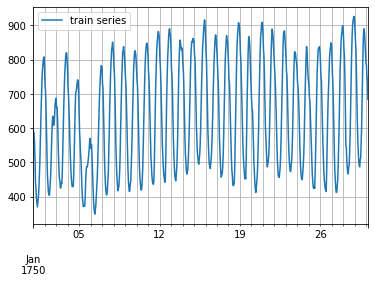

In [6]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which='both')
plt.legend(['train series'], loc='upper left')
plt.show()

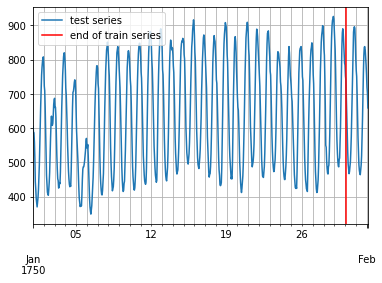

In [7]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [8]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


# Custom Datasets

In [9]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series

In [10]:
from gluonts.dataset.common import ListDataset

# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset([{'target': x, 'start': start}
                        for x in custom_dataset[:, :-prediction_length]],
                       freq=freq)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset([{'target': x, 'start': start}
                       for x in custom_dataset],
                      freq=freq)

In [11]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx.trainer import Trainer


estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer=Trainer(epochs=5,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100
                   )
)

In [12]:
predictor = estimator.train(dataset.train)

100%|██████████| 100/100 [00:00<00:00, 127.77it/s, epoch=5/5, avg_epoch_loss=4.71]


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


In [13]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

<AxesSubplot:>

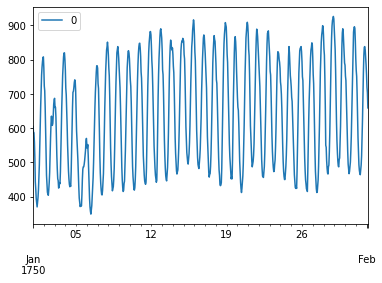

In [16]:
# first entry of the time series list
ts_entry = tss[0]
ts_entry.plot()

In [15]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([605., 586., 586., 559., 511.], dtype=float32)

In [17]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))

In [18]:
# first 5 values
dataset_test_entry['target'][:5]

array([605., 586., 586., 559., 511.], dtype=float32)

In [19]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [20]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")


Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00:00
Frequency of the time series: H


In [21]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [667.8061  607.50903 530.2545  500.13968 472.49194 401.75317 427.6837
 450.2475  481.25375 602.5902  567.83936 762.0158  760.04297 751.14764
 877.6128  846.31384 822.12006 839.06476 926.8947  949.97565 890.6856
 799.285   723.877   699.2649  657.4939  560.79517 500.2326  466.9936
 419.7997  420.41907 483.14587 466.87543 536.7342  469.8365  647.70404
 656.1582  625.5223  820.0934  873.89233 816.3526  988.269   968.25476
 990.1213  904.40283 844.6365  831.71454 800.79346 766.4232 ]
0.5-quantile (median) of the future window:
 [655.57684 615.86115 519.7685  497.81833 459.8371  407.6818  422.19437
 472.94736 487.97446 608.3582  569.6597  755.63306 772.6976  746.52704
 878.6433  846.5831  862.695   847.85706 932.4735  946.65094 902.8001
 799.81714 713.7136  683.306   650.5441  561.7397  500.35922 462.9698
 434.64908 420.36838 495.40488 467.7556  547.8249  471.73322 655.9494
 644.30554 633.83276 825.67413 873.4156  810.93585 996.08356 953.9744
 966.1853  910.02277

In [22]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

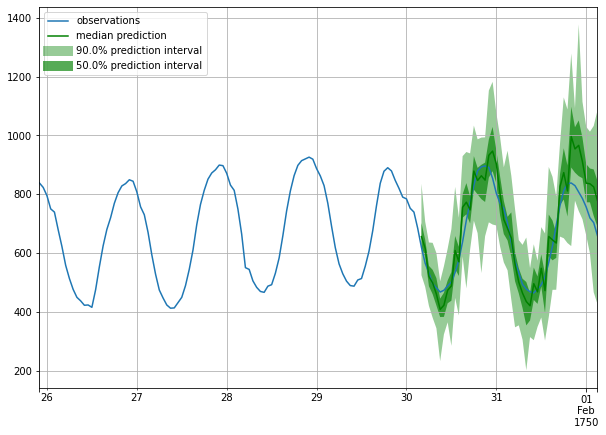

In [23]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [24]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 414/414 [00:01<00:00, 255.82it/s]


In [25]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 15667116.632577864,
    "abs_error": 11873376.515518188,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 4.950768470812258,
    "MAPE": 0.27342859087037835,
    "sMAPE": 0.20339743092049575,
    "OWA": NaN,
    "MSIS": 65.5043918712387,
    "QuantileLoss[0.1]": 5287422.769451332,
    "Coverage[0.1]": 0.10210346215780998,
    "QuantileLoss[0.5]": 11873376.35326767,
    "Coverage[0.5]": 0.4839975845410628,
    "QuantileLoss[0.9]": 7287162.790706347,
    "Coverage[0.9]": 0.8706219806763285,
    "RMSE": 3958.1708695529887,
    "NRMSE": 0.5403777521657436,
    "ND": 0.08157096189056846,
    "wQuantileLoss[0.1]": 0.03632497972775821,
    "wQuantileLoss[0.5]": 0.08157096077589557,
    "wQuantileLoss[0.9]": 0.05006333939753225,
    "mean_absolute_QuantileLoss": 8149320.63780845,
    "mean_wQuantileLoss": 0.05598642663372868,
    "MAE_Coverage": 0.01582796564680625
}


In [26]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0.0,4808.452474,2674.678711,31644.0,659.250000,42.371302,1.315099,0.082811,0.080007,NaN,12.970103,1008.303302,0.0000,2674.678741,0.541667,1450.242413,1.000000
1,1.0,188966.479167,18254.335938,124149.0,2586.437500,165.107988,2.303333,0.142448,0.130598,NaN,15.203445,4591.161060,0.1875,18254.335815,0.937500,8864.316113,1.000000
2,2.0,32577.934896,6818.952148,65030.0,1354.791667,78.889053,1.800776,0.099695,0.106781,NaN,13.584369,3740.700867,0.0000,6818.952637,0.104167,2269.757751,0.770833
3,3.0,340675.541667,20509.820312,235783.0,4912.145833,258.982249,1.649873,0.086990,0.087415,NaN,15.453974,10304.339648,0.0625,20509.820801,0.416667,9460.873047,0.916667
4,4.0,130270.750000,12610.747070,131088.0,2731.000000,200.494083,1.310382,0.095761,0.090503,NaN,12.837133,4561.339893,0.0625,12610.746826,0.645833,7557.228125,1.000000


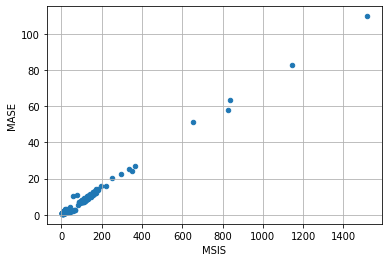

In [27]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()